## How to align the data

We coherently de-dispersed within channels but did not apply any time shifting. This function will use the start times of each channel and the DM to correct so the pulse is aligned. 

## All the packages you need

In [1]:
import h5py 
import numpy as np
from chime_frb_constants import FPGA_DELTA_FREQ_MHZ, K_DM # chime_frb_constants should be open access
import matplotlib.pyplot as plt

## Functions (form baseband-analysis, but with a slight modification since we read with h5py)

In [8]:
def get_freq(data, factor=1):
    """Find frequencies for BBData instance."""
    f = data["index_map"]['freq']['centre']
    if factor % 2 == 0:
        shift = (np.arange(-factor // 2, factor // 2) + 0.5) / factor
    else:
        shift = (np.arange(-factor // 2, factor // 2) + 1.0) / factor
    shift *= FPGA_DELTA_FREQ_MHZ
    freq = np.ravel(f.repeat(factor).reshape([-1, factor]) + shift)
    f_id = sorted(data["index_map"]["freq"]["id"])
    freq_id = np.repeat(f_id, factor) * factor + np.tile(np.arange(factor), len(f_id))
    return freq_id, freq


def delay_across_the_band(
    DM: float, freq_low: float = 400.390625, freq_high: float = 800
) -> float:
    """
    Return the delay in seconds caused by dispersion.

    It is assumed that Dispersion Measure (DM) in cm-3 pc, and the emitted
    frequency (freq_emitted) of the pulsar in MHz.

    Parameters
    ----------
    DM : float
        Dispersion measure.
    freq_low : float, optional
        Lowest observing frequency in MHz, by default 400
    freq_high : float, optional
        Highest observing frequency in MHz, by default 800

    Returns
    -------
    float
        Delay across the band.
    """
    return K_DM * DM * (1.0 / freq_low**2 - 1.0 / freq_high**2)

def incoherent_dedisp(
    data,
    DM,
    factor=1,
    matrix_in=None,
    downsampled_time=1,
    fill_wfall=True,
    freq=None,
    f_ref=None,
    t_ref=None,
):
    """
    Apply incoherent dedispersion.

    Parameters
    ----------
    data: `BBData`
        Data to dedisperse.
    DM: float
        DM to apply for dedispersion.
    factor: int, default 1
       Time downsampling factor.
    matrix_in: `ndarray`
        Defaults to tiedbeam_baseband data.
    downsampled_time: int
    fill_wfall: bool
        If True, fill the waterfall with zeros for non-selected frequencies.
        Default True.
    freq: tuple (int or float, float)
        Frequency channel and frequency.

    Returns
    -------
    ndarray of complex128:
        Waterfall data.
    float:
        Frequency
    int:
        Frequency channel id.

    """
    if matrix_in is None:
        matrix_in = data["tiedbeam_baseband"][:]
    matrix_in = matrix_in.copy()
    wfall = np.zeros_like(matrix_in)

    if freq is None:
        f_id, f = get_freq(data, factor=factor)
    else:
        f_id, f = freq
    if f_ref is None:
        f_ref = min(f)
    f_id_ref = f_id[f_ref == f]

    if t_ref is None:
        t_ref = (
            data["time0"]["ctime"][f_id_ref == f_id]
            + data["time0"]["ctime_offset"][f_id_ref == f_id]
        )

    dt = data.attrs["delta_time"] * downsampled_time

    for i in range(matrix_in.shape[0]):
        j = i // factor
        t_shift = data["time0"]["ctime"][j] + data["time0"]["ctime_offset"][j] - t_ref
        start_t = t_shift + delay_across_the_band(DM, f_ref, f[i])
        bins_shift = np.round(start_t / dt / factor).astype(int)
        wfall[i] = np.roll(matrix_in[i], bins_shift, axis=-1)

    if fill_wfall:
        wfall_filled = np.zeros(
            (f_id.max() + 1,) + (wfall.shape[1], wfall.shape[2]), dtype=wfall.dtype
        )
        wfall_filled[f_id] = wfall
        return wfall_filled, f, f_id
    else:
        return wfall, f, f_id

## Read in file

In [4]:
file ='/arc/home/aatkinson/beamformed_conjunction1120145754_dedispersed_singlebeam.h5'
data =h5py.File(file)

## Plot without correction

Text(0.5, 1.0, '/arc/home/aatkinson/beamformed_conjunction1120145754_dedispersed_singlebeam.h5')

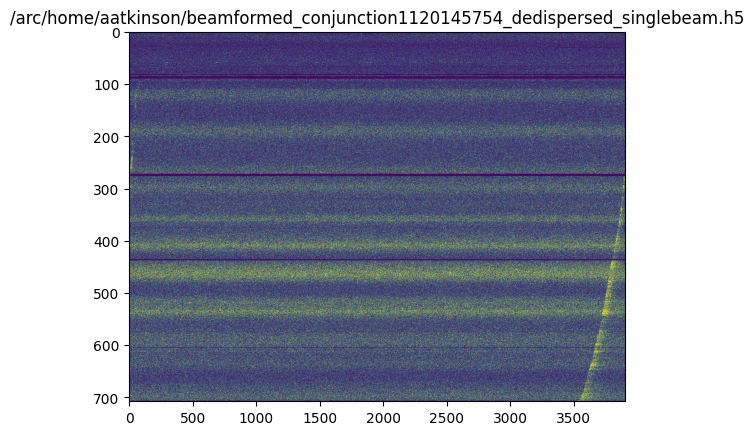

In [5]:
d = np.array(data['tiedbeam_baseband'])
I = np.abs(d[:,0, :])**2
vmin , vmax = np.percentile(I, [5,95])
plt.imshow(I, aspect = 'auto', vmin= vmin, vmax = vmax)
plt.title(str(file))

## Apply alignment

In [9]:
d_align, freqs, freq_id = incoherent_dedisp(data, 56.700252525252516, fill_wfall = False)

## Plot after alignment

Text(0.5, 1.0, '/arc/home/aatkinson/beamformed_conjunction1120145754_dedispersed_singlebeam.h5')

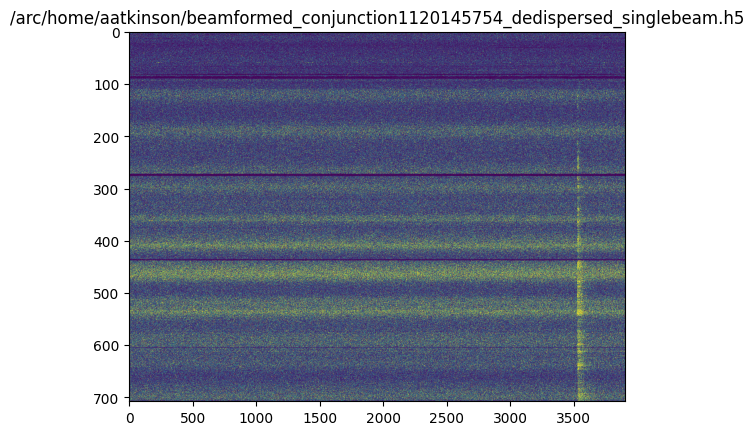

In [10]:
I_align = np.abs(d_align[:,0, :])**2
vmin , vmax = np.percentile(I, [5,95])
plt.imshow(I_align, aspect = 'auto', vmin= vmin, vmax = vmax)
plt.title(str(file))